In [1]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import scipy.stats as st
import random 
from scipy.optimize import curve_fit
import math
import time

%matplotlib inline 

plt.rcParams['figure.dpi'] = 100
plt.rcParams['pdf.fonttype'] = 42 # to true type
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 10

In [3]:
geneticcode = {'ggg':'G', 'gga':'G', 'ggc':'G', 'ggt':'G','gag':'E', 'gaa':'E', 'gac':'D', 'gat':'D','gcg':'A', 'gca':'A', 'gcc':'A', 'gct':'A',
               'gtg':'V', 'gta':'V', 'gtc':'V', 'gtt':'V','agg':'R', 'aga':'R', 'agc':'S', 'agt':'S','aag':'K', 'aaa':'K', 'aac':'N', 'aat':'N',
               'acg':'T', 'aca':'T', 'acc':'T', 'act':'T','atg':'M', 'ata':'I', 'atc':'I', 'att':'I','cgg':'R', 'cga':'R', 'cgc':'R', 'cgt':'R',
               'cag':'Q', 'caa':'Q', 'cac':'H', 'cat':'H','ccg':'P', 'cca':'P', 'ccc':'P', 'cct':'P','ctg':'L', 'cta':'L', 'ctc':'L', 'ctt':'L',
               'tgg':'W', 'tga':'*', 'tgc':'C', 'tgt':'C','tag':'*', 'taa':'*', 'tac':'Y', 'tat':'Y','tcg':'S', 'tca':'S', 'tcc':'S', 'tct':'S','ttg':'L', 'tta':'L', 'ttc':'F', 'ttt':'F'}

def translateDNA(seq):
    i = 0
    aa = ""
    while i <= len(seq)-3:
        aa += geneticcode[seq[i:i+3].lower()]
        i +=3
    return aa

def rev_comp(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A','a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
    return "".join(complement.get(base, base) for base in reversed(seq))

def heatmap(mat, filename = 'heatmap.png', labels = False):
    fig,ax = plt.subplots()
    heatmap = ax.pcolormesh(mat)#,cmap=plt.cm.PRGn)
    # want a more natural, table-like display
    cbar = plt.colorbar(heatmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(mat.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(mat.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xbound(0,mat.shape[1])
    ax.set_ybound(0,mat.shape[0])
    
    if labels:
        ax.set_xticklabels(labels[0], minor=False)
        ax.set_yticklabels(labels[1], minor=False)
    
    ax.grid(False)
    plt.savefig(filename)

In [4]:
#dna 2 identification number
d2i = {}

In [7]:
starttime = time.time()
for sID in range(0,55):
    handle = open("raw_read_dicts/rrd"+str(sID)+".csv",'r')
    for line in handle:
        (seq,count) = line.rstrip().split(',')
        count = int(count)
        if seq not in d2i:
            d2i[seq] = count
        else:
            d2i[seq] += count
    handle.close()
    print "completed sample",sID,"\t",round((time.time()-starttime)/60.,2), "min\t", len(d2i),"unique seqs"
dict_handle = open("raw_read_dicts/seqs_from1-54.csv",'w')
for seq in d2i:
    if d2i[seq]>1:
        dict_handle.write(seq+","+str(d2i[seq])+"\n")
dict_handle.close()

completed sample 0 	0.0 min	310782 unique seqs
completed sample 1 	0.01 min	664012 unique seqs
completed sample 2 	0.02 min	1041847 unique seqs
completed sample 3 	0.02 min	1376511 unique seqs
completed sample 4 	0.03 min	1591354 unique seqs
completed sample 5 	0.03 min	1627221 unique seqs
completed sample 6 	0.03 min	1715936 unique seqs
completed sample 7 	0.04 min	1929318 unique seqs
completed sample 8 	0.04 min	1987409 unique seqs
completed sample 9 	0.04 min	2053165 unique seqs
completed sample 10 	0.05 min	2492066 unique seqs
completed sample 11 	0.06 min	2767836 unique seqs
completed sample 12 	0.07 min	3218492 unique seqs
completed sample 13 	0.08 min	3626912 unique seqs
completed sample 14 	0.08 min	3737689 unique seqs
completed sample 15 	0.08 min	3790086 unique seqs
completed sample 16 	0.09 min	3906821 unique seqs
completed sample 17 	0.09 min	3951012 unique seqs
completed sample 18 	0.09 min	3968457 unique seqs
completed sample 19 	0.09 min	3980814 unique seqs
completed sam

In [8]:
#dna2index - index numbers for every nucleotide sequence present
d2i = {}
starttime = time.time()

handle = open("raw_read_dicts/seqs_from1-54.csv",'r')
for line in handle:
    (seq,count) = line.rstrip().split(',')
    count = int(count)
    if seq not in d2i:
        d2i[seq] = len(d2i) + 1
handle.close()
print "completed samples 1-54\t",round((time.time()-starttime)/60.,2), "min\t", len(d2i),"unique seqs"

#convert to 0-index
for seq in d2i:
    d2i[seq] = d2i[seq] - 1

completed samples 1-54	0.01 min	718748 unique seqs


In [10]:
#save pick
pickle.dump(d2i,open("d2i.pck","w"))

In [11]:
#array of all seqs that have at least > 1 read across all gates
raw = np.zeros((len(d2i),55))

starttime = time.time()
for sID in range(1,55):
    handle = open("raw_read_dicts/rrd"+str(sID)+".csv",'r')
    for line in handle:
        (seq,count) = line.rstrip().split(',')
        try:
            raw[d2i[seq],sID] = int(count)
        except KeyError:
            pass
    handle.close()
    print "completed sample",sID,"\t",round((time.time()-starttime)/60.,2), "min\t"

completed sample 1 	0.42 min	
completed sample 2 	0.43 min	
completed sample 3 	0.44 min	
completed sample 4 	0.45 min	
completed sample 5 	0.45 min	
completed sample 6 	0.45 min	
completed sample 7 	0.45 min	
completed sample 8 	0.46 min	
completed sample 9 	0.46 min	
completed sample 10 	0.47 min	
completed sample 11 	0.48 min	
completed sample 12 	0.49 min	
completed sample 13 	0.5 min	
completed sample 14 	0.5 min	
completed sample 15 	0.5 min	
completed sample 16 	0.5 min	
completed sample 17 	0.51 min	
completed sample 18 	0.51 min	
completed sample 19 	0.51 min	
completed sample 20 	0.51 min	
completed sample 21 	0.51 min	
completed sample 22 	0.51 min	
completed sample 23 	0.51 min	
completed sample 24 	0.51 min	
completed sample 25 	0.51 min	
completed sample 26 	0.51 min	
completed sample 27 	0.51 min	
completed sample 28 	0.51 min	
completed sample 29 	0.52 min	
completed sample 30 	0.52 min	
completed sample 31 	0.52 min	
completed sample 32 	0.52 min	
completed sample 33 	

In [12]:
#save as single pickle file
np.save(open("raw_counts_array.npy","w"),raw)

In [10]:
#load pickle file of raw reads
d2i = pickle.load(open("d2i.pck","r"))
raw = np.load(open("raw_counts_array.npy","r"))
print "loaded"

loaded


In [11]:
#reduce data to only dna sequences with multiple counts
#filter to only columns with total gated reads > threshold
thresh = 5
#thresholded dna2index dictionary
td2i = {}
tcounts = np.zeros(raw.shape)
for seq in d2i:
    if raw[d2i[seq],:49].sum() > thresh:
        td2i[seq] = len(td2i)
        tcounts[td2i[seq]] = raw[d2i[seq]]

# tcounts = tcounts[:len(td2i)]
# np.save(open("tcounts.npy","w"),tcounts)
# pickle.dump(td2i,open("td2i.pck","w"))
print "complete"


complete


In [6]:
#load thresholded, raw counts
tcounts = np.load(open("tcounts.npy","r"))
td2i = pickle.load(open("td2i.pck","r"))

In [7]:
#calcualte and plot pearson corr between raw reads of each sample
pearsons = np.zeros((55,55))
for i in range(1,55):
    for j in range(i+1,55):
        pearsons[i,j] = st.pearsonr(tcounts[:,i],tcounts[:,j])[0]

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


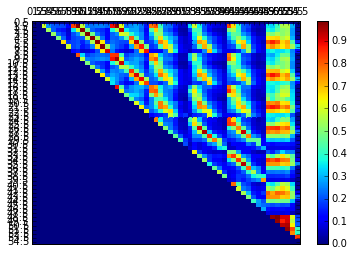

In [19]:
heatmap(pearsons, filename = "pearson R - thresholed raw reads.png")

In [12]:
##normalize each gate count
def counts2frequencies(raw_counts):
    #inputs - array of raw counts
    #outputs - array of freqs normalized by column
    frequencies = np.zeros(raw_counts.shape)
    for i in range(1,55):
        frequencies[:,i] = raw_counts[:,i]/raw_counts[:,i].sum()
    return frequencies

tfreq = counts2frequencies(tcounts)
print tfreq[:,50].sum()
np.save(open("tfreq.npy","w"),tfreq)

1.0


In [13]:
#normalize by total cell counts in each gate

from numpy import genfromtxt
gate_count = genfromtxt('gatecounts.csv', delimiter=',')
gate_freq = gate_count.copy()
for samp in range(gate_freq.shape[0]):
    gate_freq[samp] = gate_freq[samp] / gate_freq[samp].sum()

gate_freq = gate_freq.reshape((1,48))

#normalized frequency
def norm_by_cell_counts(freqs):
    nfreq = np.copy(freqs)
    for i in range(1,49):
        nfreq[:,i] = freqs[:,i]*gate_freq[0][i-1]
    return nfreq

ntfreq = norm_by_cell_counts(tfreq)
np.save(open("ntfreq.npy","w"),ntfreq)

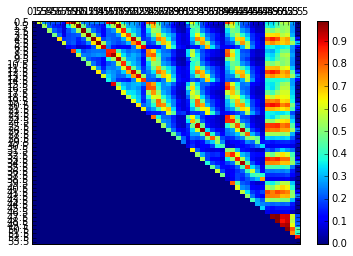

In [21]:
#calcualte and plot pearson R2 between normalized reads of each sample
import math
pearsons = np.zeros((54,54))
for i in range(1,55):
    for j in range(i+1,55):
        p = st.pearsonr(ntfreq[:,i],ntfreq[:,j])[0]
        pearsons[i-1,j-1] = p
np.save(open('pearsonR_ntfreq.npy','w'),pearsons)
heatmap(pearsons, filename = "pearson R -ntfreq.png")

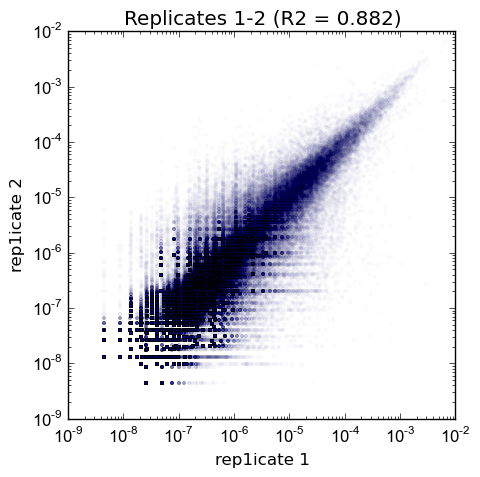

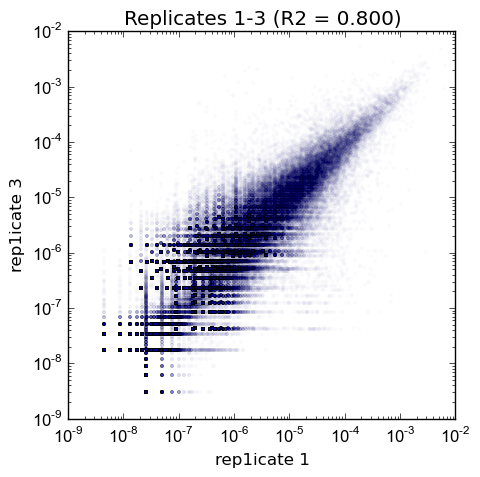

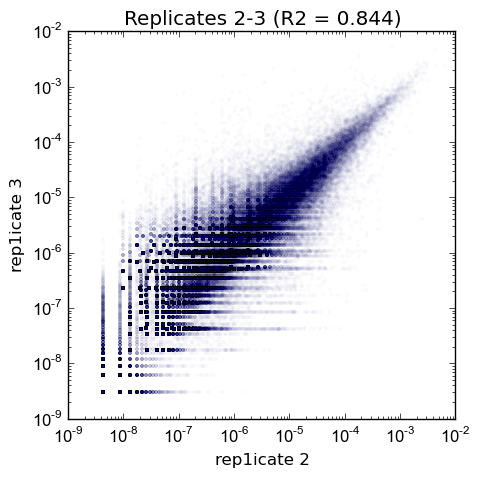

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

#plot replicate correlations
replicates[1] = np.hstack((ntfreq[:,1:9],ntfreq[:,25:33])).reshape(len(ntfreq)*16,1)
replicates[2]= np.hstack((ntfreq[:,9:17],ntfreq[:,33:41])).reshape(len(ntfreq)*16,1)
replicates[3] = np.hstack((ntfreq[:,17:25],ntfreq[:,41:49])).reshape(len(ntfreq)*16,1)

for reps in [(1,2),(1,3),(2,3)]:
    alpha = 0.001
    fig,ax = plt.subplots()
    fig.set_size_inches(5,5)
    plt.scatter(replicates[reps[0]][:], replicates[reps[1]][:], alpha =0.01,rasterized = True, marker=".")
    plt.xlabel("rep1icate %s" % reps[0])
    plt.ylabel("rep1icate %s" % reps[1])
    plt.xlim((1e-9,1e-2))
    plt.ylim((1e-9,1e-2))
    plt.semilogy()
    plt.semilogx()
    Rsquared = st.pearsonr(replicates[reps[0]], replicates[reps[1]])[0][0]
    plt.title("Replicates %s-%s (R2 = %.3f)" % (reps[0], reps[1], Rsquared))
    plt.savefig("norm_reads_ reps %s-%s.pdf" % reps, dpi = 500)